<a href="https://colab.research.google.com/github/maxiperezc/memoscopio/blob/master/HPC/PerezCoto_Maximiliano_ejercicio_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# 1 Introducción

El siguiente cuaderno realiza la norma de N de 3 dimensiones vectores en forma secuencial y parelela utilizando el procesador CPU y GPU respectivamente.

<left>$V_0 = (X_0, Y_0, Z_0)$</left>  
<left>$...$</left>

<left>$V_n = (X_n, Y_n, Z_n)$</left>  

<left>Luego,</left>

<left>$||V_n|| = \sqrt( X^2_n + Y^2_n + Z^2_n)  $</left>  

El objetivo es calcular la fuerza correspondiente a N vectores para ser utilizado en ambientes de desarrollo gráfico o con fines de investigación científica.

# Armado del Ambiente

A fines de comparar como reacciona el tiempo de ejecución en función de la cantidad de elementos procesados deben pararse como parametros:
1. La cantidad de vectores de 3 dimensiones a procesar
2. Multiplicador: Si se eligen 5 vectores y el multiplicador es 10, la siguiente iteración operará 50 vectores.
3. La cantidad de veces que se realiza el ciclo, aplicando el multiplicador a los vectores.

Por ejemplo, con los valores por defecto se procesaran 5 iteraciones en secuencial y paralelo procesando primero 5 vectores, luego 50, luego 500, luego 5.000 y finalmente 50.000, representando los tiempos finales en un gráfico 2D.

## Instalar en el cuaderno el módulo CUDA de Python:

In [9]:
!pip install pycuda

     |████████████████████████████████| 1.6MB 11.3MB/s 
     |████████████████████████████████| 71kB 12.5MB/s 
     |████████████████████████████████| 81kB 13.8MB/s 
  Created wheel for pycuda: filename=pycuda-2020.1-cp36-cp36m-linux_x86_64.whl size=621008 sha256=037f127214601b84289bc739263d6e3496e850d3c846f78df9e920dc74313c50
  Stored in directory: /root/.cache/pip/wheels/8f/78/d1/5bb826f81d9d490297a348d818ff3ee6dd6f2075b06dde6ea0
  Created wheel for pytools: filename=pytools-2020.4.3-py2.py3-none-any.whl size=61374 sha256=64d77f034c907feac3cb53cf2095e62a23ed8a7660e635814097f4a33c82fccc
  Stored in directory: /root/.cache/pip/wheels/af/c7/81/a22edb90b0b09a880468b2253bb1df8e9f503337ee15432c64
Successfully built pycuda pytools


# 2 Desarrollo CPU vs GPU

 Tiempo Total CPU:  1.251 [ms]
 Tiempo Total GPU:  0.189 [ms]
 
Eje X: cantidad vectores
Eje Y: milisegundos


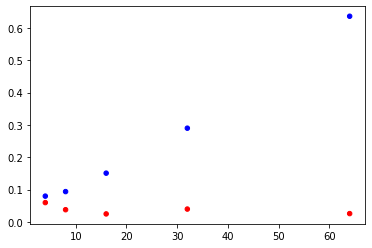

In [22]:
# --------------------------------------------
#@title 3.1 Parámetros de ejecución:
#@title cantidad de vectores de 3 dimensiones { vertical-output: true }

vectores = 4#@param {type: "number"}
multiplicador = 2#@param {type: "number"}
iteraciones = 5#@param {type: "number"}

from datetime import datetime
import numpy
import matplotlib.pyplot as plt

try:
  import pycuda.driver as cuda
  import pycuda.autoinit
  from pycuda.compiler import SourceModule

  if vectores < 1:
    raise ValueError("Error: La cantidad de vectores debe ser al menos 1.");
  if multiplicador < 1:
    raise ValueError("Error: El multiplicador de vectores debe ser al menos 1.");
  if iteraciones < 1:
    raise ValueError("Error: La cantidad de itearaciones debe ser al menos 1.");


  # CPU - Defino la función kernel que ejecutará en GPU.
  module = SourceModule("""
  __global__ void kernel_norm( int n, float *X, float *Y, float *Z, float *V )
  {
    int idx = threadIdx.x + blockIdx.x*blockDim.x;
    if( idx < n )
    {
      V[idx] = sqrt(pow(X[idx], 2) + pow(Y[idx], 2) + pow(Z[idx], 2));
    }
  }
  """)
  # CPU - Genero la función kernel.
  kernel = module.get_function("kernel_norm")

  # --------------------------------------------
  # Definición de función que transforma el tiempo en  milisegundos 
  tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0

  tiempos = []
  colores = []
  cantidades = []
  total_cpu = 0
  total_gpu = 0

  for itx in range(0, iteraciones):
    # CPU - Defino la memoria de los vectores en CPU.
    x_cpu = numpy.random.randn( vectores )
    x_cpu = x_cpu.astype( numpy.float32() )
    y_cpu = numpy.random.randn( vectores )
    y_cpu = y_cpu.astype( numpy.float32() )
    z_cpu = numpy.random.randn( vectores )
    z_cpu = y_cpu.astype( numpy.float32() )
    v_cpu = numpy.empty_like( x_cpu )
    
    # CPU - reservo la memoria GPU.
    x_gpu = cuda.mem_alloc( x_cpu.nbytes )
    y_gpu = cuda.mem_alloc( y_cpu.nbytes )
    z_gpu = cuda.mem_alloc( z_cpu.nbytes )
    v_gpu = cuda.mem_alloc( v_cpu.nbytes )
    # GPU - Copio la memoria al GPU.
    cuda.memcpy_htod( x_gpu, x_cpu )
    cuda.memcpy_htod( y_gpu, y_cpu )
    cuda.memcpy_htod( z_gpu, z_cpu )
    cuda.memcpy_htod( v_gpu, v_cpu )

    # ejecuto el proceso y mido tiempo en CPU
    tiempo_cpu = datetime.now()
    for idx in range( 0, vectores ):
      v_cpu[idx] = numpy.sqrt(pow(x_cpu[idx], 2) + pow(y_cpu[idx], 2) + pow(z_cpu[idx], 2))
    tiempo_cpu = datetime.now() - tiempo_cpu

    # Agrego el resultado de la iteracion para el render
    cantidades.append(vectores)
    colores.append('blue')
    cpu_ms = tiempo_en_ms(tiempo_cpu)
    total_cpu += cpu_ms
    tiempos.append(cpu_ms)

    # ejecuto el proceso y mido tiempo en GPU
    tiempo_gpu = datetime.now()
    dim_hilo = 256
    dim_bloque = numpy.int( (vectores+dim_hilo-1) / dim_hilo )
    kernel( numpy.int32(vectores), x_gpu, y_gpu, z_gpu, v_gpu, block=( dim_hilo, 1, 1 ),grid=(dim_bloque, 1,1) )
    tiempo_gpu = datetime.now() - tiempo_gpu
    # GPU - Copio el resultado desde la memoria GPU.
    cuda.memcpy_dtoh( v_cpu, v_gpu )

    # Agrego el resultado de la iteracion para el render
    cantidades.append(vectores)
    colores.append('red')
    gpu_ms = tiempo_en_ms(tiempo_gpu)
    total_gpu += gpu_ms
    tiempos.append(gpu_ms)

    vectores *= multiplicador
  
  # --------------------------------------------


  # CPU - Informo el resultado - comentado
  # solo para verificar que el resultado es el mismo durante el desarrollo
  """
  print( "------------------------------------")
  print( "X: " )
  print( x_cpu )
  print( "------------------------------------")
  print( "Y: " )
  print( y_cpu )
  print( "------------------------------------")
  print( "Z: " )
  print( z_cpu )
  print( "------------------------------------")
  print( "V: " )
  print( v_cpu )
  print( "------------------------------------")
  print( "\n\n")
  """

  tiempo_total = datetime.now() - tiempo_total
  print("\033[94m Tiempo Total CPU: ", total_cpu, "[ms]" )
  print("\033[91m Tiempo Total GPU: ", total_gpu, "[ms]" )

  print("\033[0m \nEje X: cantidad vectores")
  print("Eje Y: milisegundos")

  fig, ax = plt.subplots()
  scat = ax.scatter(cantidades, tiempos, c=colores, s=20, vmin=0, vmax=1)

  

except ModuleNotFoundError:
  print("Error: debe cambiar el entorno a GPU e instalar CUDA en el paso anterior antes de continuar.")
except ValueError as VR:
  print(VR)

---
# 4 Tabla de pasos de ejecución del programa

 Procesador | Función | Detalle
------------|---------|----------
CPU      |  @param                | Lectura del tamaño de vectores desde Colab.
CPU      |  import                | Importa los módulos para funcionar.
CPU      |  datetime.now()        | Toma el tiempo inicial.
CPU      |  numpy.random.randn( Cantidad ) | Inicializa los vectores A, B y R.
CPU      |  for...                | Realiza la norma de los vectores $(X_0, Y_0, Z_0) ... (X_n, Y_n, Z_n) $ , guardando el resultado en $V_n$. 
CPU      |  datetime.now()        | Toma el tiempo final.
CPU      |  print()               | Informa los resultados.




 Procesador | Funciòn | Detalle
------------|---------|----------
CPU      |  @param                | Lectura del tamaño de vectores desde Colab.
CPU      |  import                | Importa los módulos para funcionar.
CPU      |  datetime.now()        | Toma el tiempo actual.
CPU      |  numpy.random.randn( Cantidad ) | Inicializa los vectoes A, B y R.
**GPU**  |  cuda.mem_alloc()      | Reserva la memoria en GPU.
**GPU**  |  cuda.memcpy_htod()    | Copia las memorias desde el CPU al GPU.
CPU      |  SourceModule()        | Define el código del kernel 
CPU      |  module.get_function() | Genera la función del kernel GPU
CPU      |  dim_tx/dim_bx         | Calcula las dimensiones.
**GPU**  |  kernel()              | Ejecuta el kernel en GPU
CPU      |  cuda.memcpy_dtoh( )   | Copia el resultado desde GPU memoria A a CPU memoria R.
CPU      |  print()               | Informo los resultados.



---
# 5 Conclusiones

Si bien el ejercicio realizado no presenta una gran complejidad, creo que fue necesario realizar algo simple para familiarizarme con el lenguaje de Python y como es el funcionamiento de los cuadernos de Colab. Tanto para la declaración de funciones, como de variables y excepciones. Tambien me sirvio como puntapie para aprender sobre las distintas estructuras y funciones que ofrece Numpy[6]

En cuanto a los resultado, si bien el calculo realizado no requiere de mucho calculo por parte de la CPU, al comparar los valores entre la ejecición en serie y la ejecución en paralelo se ve una "ENORME" diferencia.

En promedio, con la ejecución en serie obtuve un resultado de 63.221 [ms] (tamando 10 ejecuciones con 10000 objetos). Por otra parte, con la ejecución en paralelo, el calculo de las diferentes energias se resolvió en un promedio de 0.089 [ms].

### Pasos mas relevantes

1- Reservar memoria en GPU (cuda.mem_alloc).

2- Copiar datos en memoria GPU (cuda.memcpy_htod).

3- Definir la función que va a ejecutar el Kernel.

4- Calcular las dimensiones.


---

# 6 Bibliografia

[1] MARKDOWN SYNTAX Colab: [PDF](https://github.com/wvaliente/SOA_HPC/blob/main/Documentos/markdown-cheatsheet-online.pdf)

[2] Introducción a Python: [Página Colab](https://github.com/wvaliente/SOA_HPC/blob/main/Documentos/Python_Basico.ipynb) 

[3] Documentación PyCUDA: [WEB](https://documen.tician.de/pycuda/index.html)

[4] Repositorio de PyCUDA: [WEB](https://pypi.python.org/pypi/pycuda)


